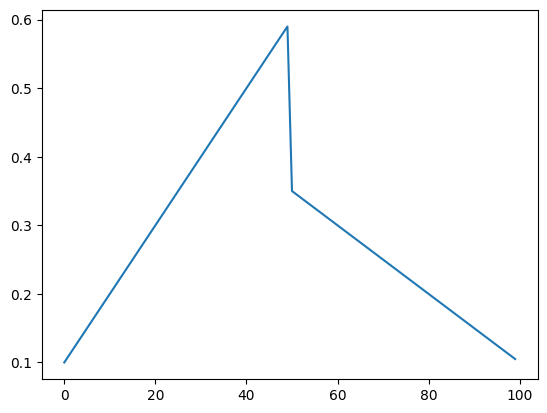

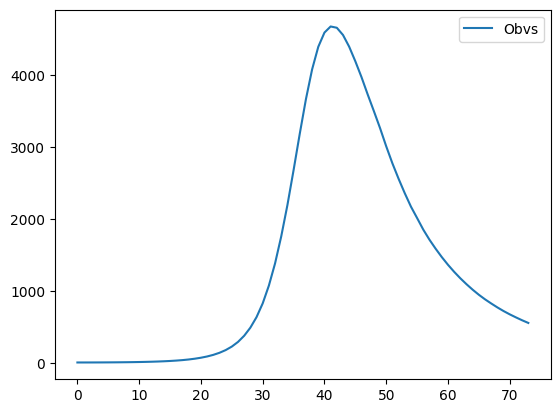

In [28]:
import numpy as np
from scipy.stats import nbinom
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
import pandas as pd


def RHS_H(t,state,param):
    #params has all the parameters – beta, gamma
    #state is a numpy array

        S,I,R,H,new_H = state #unpack the state variables
        N = S + I + R + H #compute the total population 

        new_H = (1/param['D'])*(param['gamma']) * I

        '''The state transitions of the ODE model is below'''
        dS = -param['beta'](int(t))*(S*I)/N + (1/param['L'])*R 
        dI = param['beta'](int(t))*S*I/N-(1/param['D'])*I
        dR = (1/param['hosp']) * H + ((1/param['D'])*(1-(param['gamma']))*I)-(1/param['L'])*R 
        dH = (1/param['D'])*(param['gamma']) * I - (1/param['hosp']) * H 

        return np.array([dS,dI,dR,dH,new_H])

def Jacobian(t,state,par):

    S,I,R,H,new_H = state
    N = S + I + R + H #compute the total population 
    return np.array([[-I*par.beta(int(t))/N,
                        -S*par.beta(int(t))/N,
                        1/par.L,0,0,],
                        [I*par.beta(int(t))/N,
                        S*par.beta(int(t))/N - 1/par.D,0,0,0,],
                        [0,(1 - par.gamma)/par.D,
                        -1/par.L,1/par.hosp,0,],
                        [0,par.gamma/par.D,0,
                        -1/par.hosp,0,],
                        [0,par.gamma/par.D,0,0,0,],])

pop = 1_000_000
initial_infected = 1000
y0 = [pop-initial_infected,initial_infected,0,0,0]
t_span = [0.0,75.0]

def beta(t):
    if(t < 50):
        return 0.1 + 0.01 * t; 
    return 0.6 - 0.005 * t


plt.plot([beta(t) for t in range(100)])
plt.show()

par={
"beta":beta,
"gamma":0.1,
"eta":0.1,
"std":10,
"hosp":15,
"L":90,
"D":10}
sol =  solve_ivp(fun=lambda t,z: RHS_H(t,z,par), 
                    jac=lambda t,z:Jacobian(t,z,par), 
                    t_span=t_span,
                    t_eval= np.linspace(t_span[0],t_span[1],int(t_span[1] - t_span[0])),
                    y0=y0,
                    method='LSODA')

labels = ['S','I','R','H','Obvs'] 
for i in range(4,sol.y.shape[0]): 
    if(i == 4): 
        plt.plot(np.diff(sol.y[i,:]),label = labels[i])
    else: 
        plt.plot(sol.y[i,:],label = labels[i])
          
    
plt.legend()
